In [1]:
# python 2/3 compatibility
from __future__ import print_function
# numerical python
import numpy as np
# file management tools
import glob
import os
# good module for timing tests
import time
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# ability to read/write fits files
from astropy.io import fits
# fancy image combination technique
from astropy.stats import sigma_clip
from astropy.stats import SigmaClip
# median absolute deviation: for photometry
from astropy.stats import mad_std
# photometric utilities
from photutils import DAOStarFinder, aperture_photometry, CircularAperture, CircularAnnulus, Background2D, MedianBackground
# periodograms
from astropy.stats import LombScargle
from regions import read_ds9#, write_ds9
from astropy.wcs import WCS

import numpy.ma as ma
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)

In [2]:
from Sarah_DiffPhotometry import *
from importlib import reload as reload

## Initial setup: 

You will need to define the data directory where your images exist, and ideally a region file that you have created for the target members in your field.

**For the in-class example with WASP-12, there's only one target of interest so we will not use a regions file.**

In [3]:
datadir = '/Users/sarah/Downloads/WASP-12b/'

im = glob.glob(datadir+ '*.fits')

# For WASP-12 data
target = "WASP12"
wcs_image = im[0]


# # For your own data, modify as needed
# target = 'your target name, or other convention'
# wcs_image = '/Volumes/ARCTURUS/WIYN09/RegionFiles/' + target+ '/' + target + '_WCS.fits'
# wcs_region = '/Volumes/ARCTURUS/WIYN09/RegionFiles/' + target + '/' + target + '_VZ_sm.reg'

In [4]:
print(f"Number of images found: {len(im)}")

Number of images found: 230


In [5]:
aprad=30.  # aperture radius for WASP-12 with larger FWHM
skybuff=14.  # sky annulus inner radius
skywidth=18.  # sky annulus outer radius

In [6]:
# sensitivities for star finding
nsigma=30. # detection threshold in sigma (decrease for HDI data)
FWHM=10. # pixels (decrease for HDI data)

In [7]:
## do starfind on one of the images.
xpos, ypos, nstars = StarFind(im[3], FWHM, nsigma)

begin: DAOStarFinder
found 89 stars


In [8]:
#find ra, dec coordinates of stars
hdr_wcs = fits.getheader(wcs_image)
w = construct_astrometry(hdr_wcs)
ra, dec = w.wcs_pix2world(xpos, ypos,1)

Found 230 images
making apertures


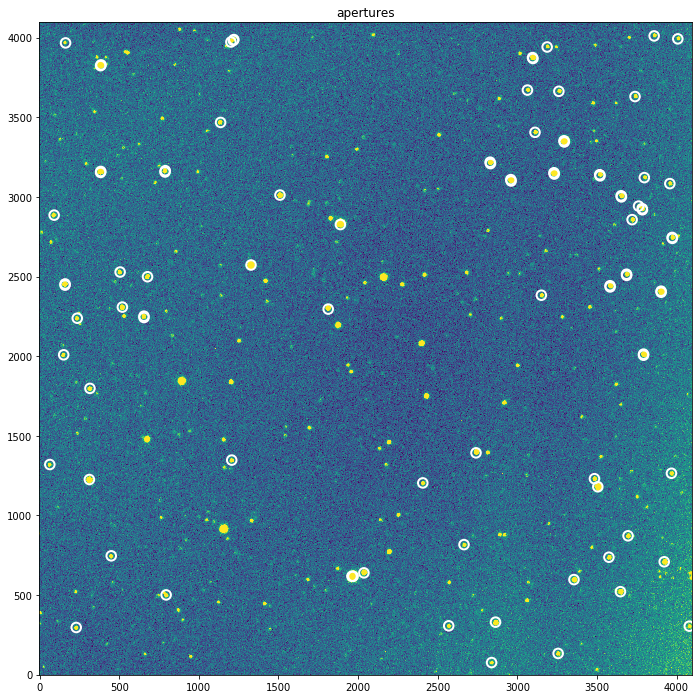

running aperture photometry on image:  0
running aperture photometry on image:  25
running aperture photometry on image:  51
running aperture photometry on image:  76
running aperture photometry on image:  102
running aperture photometry on image:  127
running aperture photometry on image:  153
running aperture photometry on image:  178
running aperture photometry on image:  204


In [9]:
# Note that you will need to update the "timekey" keyword to pick the right header keyword from AIJ! 

times, Photometry_initial = doPhotometry(im, xpos, ypos,aprad, skybuff, skywidth, timekey='JD_UTC')

In [10]:
ePhotometry = doPhotometryError(im,xpos, ypos, aprad, skybuff, skywidth, Photometry_initial, manual=True, xboxcorner=2000, yboxcorner=2000, boxsize=200)

Found 230 images
running error analysis on image  0
Scatter in sky values:  1880.70724597627 , uncertainty in mean sky brightness:  500.0200200834821
running error analysis on image  25
Scatter in sky values:  2182.434782816262 , uncertainty in mean sky brightness:  580.2397402729241
running error analysis on image  51
Scatter in sky values:  1783.0993627647756 , uncertainty in mean sky brightness:  474.0691998119397
running error analysis on image  76
Scatter in sky values:  1924.988726449576 , uncertainty in mean sky brightness:  511.7930521717884
running error analysis on image  102
Scatter in sky values:  1922.4582932157437 , uncertainty in mean sky brightness:  511.12029075232357
running error analysis on image  127
Scatter in sky values:  1672.4088545231743 , uncertainty in mean sky brightness:  444.64012717321253
running error analysis on image  153
Scatter in sky values:  1844.6739553831555 , uncertainty in mean sky brightness:  490.4399183825976
running error analysis on image

In [11]:
#find ra, dec coordinates of stars
hdr_wcs = fits.getheader(wcs_image)
w = construct_astrometry(hdr_wcs)
ra, dec = w.wcs_pix2world(xpos, ypos,1)

# wcs_region=([2402],[2076])

# memberlist = wcs_region

ra_in, dec_in = w.wcs_pix2world([2402],[2076],1)
memberlist = (ra_in, dec_in)


idx, RA, DEC = target_list(memberlist, ra, dec)

In [12]:
Photometry, cPhotometry = detrend(Photometry_initial, ePhotometry, nstars)

starting detrending on star number  0 / 89
median photometry on star 0: 186618.42802631645
starting detrending on star number  9 / 89
median photometry on star 9: 27557560.079199843
starting detrending on star number  19 / 89
median photometry on star 19: 1969500.5471161704
starting detrending on star number  29 / 89
median photometry on star 29: 289400.72268020664
starting detrending on star number  39 / 89
median photometry on star 39: 789841.0656136384
starting detrending on star number  49 / 89
median photometry on star 49: 353502.9403839172
starting detrending on star number  59 / 89
median photometry on star 59: 2815972.594508654
starting detrending on star number  69 / 89
median photometry on star 69: 899146.0911009205
starting detrending on star number  79 / 89
median photometry on star 79: 4320386.746988289


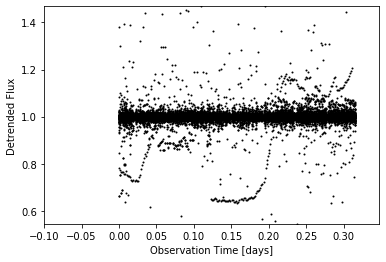

In [13]:
plotPhotometry(times,cPhotometry)

(89, 230) (89, 230)
-----
(89,)
(array([ 0,  1,  2,  4,  6, 11, 13, 14, 15, 16, 18, 20, 21, 22, 23, 25, 27,
       29, 30, 31, 34, 41, 42, 43, 44, 46, 47, 49, 50, 53, 57, 60, 61, 63,
       66, 68, 73, 74, 75, 76, 77, 82, 83, 87, 88]),)
(45, 230)
(45,)
(45, 230) (45, 230)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]]
(45,)
[ 12.   1.   1.   2.  25. 164.   6.   4.   3.   5.   4.   0.   2.   9.
  15.   2.   9.  27.  10.  14.   0.   6.  12.  16.  16.  46.  42.   1.
   3. 168.   2.   9.  26.  24.  13.  18.   3.   5.   2.   2.   2.  29.
  19.  11.   5.]
[ 1  2  4 20 21 25 34 49 57 75 76 77]


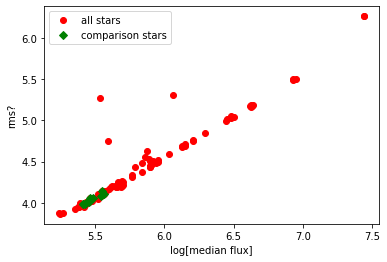

In [194]:
# Photometry
# 0. select sample whose std of error is less than 10% of all errors
# transpose it so every row is a star and every column is a different date
# 89 stars and 230 times
Photometry2 = Photometry.transpose()
ePhotometry2 = ePhotometry.transpose()

print(Photometry2.shape, ePhotometry2.shape)
print('-----')

# take the median of the error of all days for each star
ePhotometry2 = np.array(ePhotometry2)
median_ePhot = np.nanmedian(ePhotometry2, axis=1)
# order them from smallest error to largest
ind = np.argsort(median_ePhot)
print(median_ePhot.shape)
sort_err = median_ePhot[ind]
# find the error at 10%
#### CHANGE 0.1 TO WHATEVER PERCENTAGE OF ERROR YOU WANT!
percent10 = sort_err[int(0.5*len(sort_err))]
# find all stars with errors less than the 10 percent error
ref = np.where(median_ePhot <= percent10)
# create a mask of reference stars as 1 and all other as 0 so you can 
# find the index number of the final comparision stars 
initial_ref_stars = np.zeros_like(median_ePhot)
initial_ref_stars[ref] = 1.
print(ref)
# get photometry of the reference star sample
test_stars = Photometry2[ref[0],:]

print(test_stars.shape)

# go through Scholtz+2003 steps
# 1. average flux for each star
FF = np.nanmean(test_stars, axis=1)
print(FF.shape)


#2 subtract average from every value of time series for every star
flux0 = (test_stars.transpose() - FF).transpose()

print(flux0.shape, test_stars.shape)

# 3 calculate average flux0 and standard dev for all stars at each time
mean_flux0 = np.nanmean(flux0, axis=0)
std_flux0 = np.nanstd(flux0, axis=0)
# print(mean_flux0, std_flux0)

#6. calculate quality number test : examine intrinsic variability compared to other reference stars 
test = abs((flux0 - mean_flux0)) >= std_flux0
test = test.transpose() * 1.

print(test)
tot_test = np.sum(test,axis=0)
print(tot_test.shape)

# stars with test < 3 are selected as reference stars 
ind = np.where(tot_test <3)
print(tot_test)

# pull out original index of comparison stars 
comparison_star_index = ref[0][ind[0]]
print(comparison_star_index)

# calculate rms?
rms = np.nanstd(Photometry2, axis=1)

# plot flux vs rms 
plt.plot(np.log10(np.nanmedian(Photometry2, axis=1)), np.log10(rms), 'ro', label='all stars')
plt.plot(np.log10(np.nanmedian(Photometry2, axis=1)[comparison_star_index]), np.log10(rms[comparison_star_index]), 'gD'
        , label='comparison stars')
plt.xlabel('log[median flux]')
plt.ylabel('rms?')
plt.legend()
plt.show()



In [180]:
len(most_accurate)

6

Bin Percentiles to check: [  0.  20.  40.  60.  80. 100.]


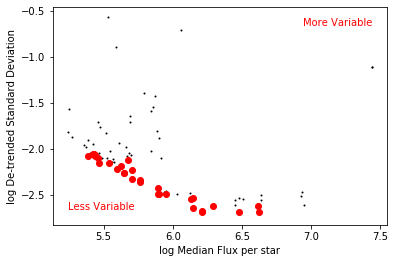

In [107]:
most_accurate = findComparisonStars(Photometry, cPhotometry) # comp_num= (can set this)

In [ ]:
dPhotometry, edPhotometry, tePhotometry  = runDifferentialPhotometry(Photometry, ePhotometry, nstars, most_accurate)

In [ ]:
# memberlist = wcs_region

# ra_in, dec_in = w.wcs_pix2world([2402],[2076],1)
# memberlist = (ra_in, dec_in)



diffPhot_IndividualStars(datadir, memberlist, ra, dec, xpos, ypos, dPhotometry, edPhotometry, tePhotometry,times, target, wcs_image, most_accurate)

In [ ]:
data2 = np.load(datadir + 'differentialPhot_field' + target + '.npz')


In [ ]:
# What is an .npz file?
# your answer here:


data2.files

# Plot the lightcurve here!


In [ ]:
# your code